In [1]:
# Importing packages

import pandas as pd
import numpy as np
import re
import plotnine as p9
import matplotlib.pyplot as plt

In [2]:
# Setting routes for reading in csv data

data_masterplan_input_target = 'test_mp_data.csv'
phasing_logic_input_target = 'phasing_logic_matrix.csv'

# Reading in masterplan data and phasing logic matrix

data_masterplan_input =  pd.read_csv(data_masterplan_input_target)
phasing_logic_input = pd.read_csv(phasing_logic_input_target).rename({'delivery_status':'Phasing_Note'},axis = 1)

# Reading csv containing size of housing units data

dwelling_sizes_input = pd.read_csv('dwelling_sizes.csv')
dwelling_sizes_input.head(2)

,land_use,size_gfa,source
0,Residential - Villas Emiratis,700,CBRE estimate
1,Residential - Villas Non-Emiratis,400,CBRE estimate


In [3]:
# Dropnas from the project ID column from the main data_masterplan_input data frame and filtering out masterplans not to be phased

data_masterplan_input = data_masterplan_input.dropna(subset = ['ProjectID'],axis = 0).reset_index(drop = True)
data_masterplan_input = data_masterplan_input[data_masterplan_input['Include in Summary'] == 'Yes']
data_masterplan_input.head(1)


,Municipality,ProjectID,Include in Summary,Project Name,DistrictID,District,Regional_Subregional Centre_District,District Centre,Centre or Non Centre,Approved,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,Abu Dhabi,Riyadh,Yes,Madinat Al Riyadh,1240,MADINAT AL RIYAD,MADINAT AL RIYAD,Al Shamkah South,Centre,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Find columns with a '%' sign and the column immediately to the left in the main masterplan input dataframe

columns_with_percent = [col for col in data_masterplan_input.columns if '%' in col]

selected_columns = []

for col in columns_with_percent:

    # Find the index of the column with a '%' sign
    
    col_index = data_masterplan_input.columns.get_loc(col)
    # Append the column to the left if it exists
    
    if col_index > 0:
        selected_columns.append(data_masterplan_input.columns[col_index - 1])
    
    # Append the column with a '%' sign
    
    selected_columns.append(col)

# Select the identified columns from the DataFrame
committed_development = data_masterplan_input[selected_columns]
committed_development = pd.concat([data_masterplan_input[['ProjectID','Phasing_Note','Approved Completion Year']],committed_development],axis = 1)
committed_development.head(1)

,ProjectID,Phasing_Note,Approved Completion Year,Residential - Villas Emiratis (Units),Residential - Villas Emiratis % Committed,Residential - Villas Non-Emiratis (Units),Residential - Villas Non-Emiratis % Committed,Residential - Apartments (Units),Residential - Apartments % Committed,Residential - Labour Accommodation (Units),...,Hotel (Units),Hotel % Committed,Community Facilities (GFA),Community Facilities % Committed,Healthcare (GFA),Healthcare % Committed,Education (GFA),Education % Committed,Other (GFA),Other % Committed
0,Riyadh,Partially Delivered,NaN,0.0,1.0,0.0,0.0,0,1.0,0,...,306.25,0.0,0,0,0.0,1.0,0.0,1.0,0,1.0


In [5]:
# Creating dataframe that contains land uses for joining onto adhoc dataframes later in the phasing process.

land_use_df = pd.DataFrame({'land_use':selected_columns})
land_use_df = land_use_df[~land_use_df['land_use'].str.contains('%')].reset_index(drop = True)
land_use_df.head(n = 1)

,land_use
0,Residential - Villas Emiratis (Units)


In [6]:
# Setting start dates of the plan

plan_start = 2024
plan_end = 2040

# Creating sequence containing all years of the plan phasing period

phasing_period = np.arange(plan_start,plan_end+1,1)
phasing_period = phasing_period.astype(str)
print(phasing_period)


['2024' '2025' '2026' '2027' '2028' '2029' '2030' '2031' '2032' '2033'
 '2034' '2035' '2036' '2037' '2038' '2039' '2040']


In [7]:
# Creating dataframe includes the manual phasing overrides

phasing_override_input = data_masterplan_input[phasing_period]
phasing_override_input = pd.concat([data_masterplan_input['ProjectID'],phasing_override_input],axis = 1)
phasing_override_input.head(n = 1)

,ProjectID,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,Riyadh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Creating data frame with phasing timeline for attaching to different development phasing pipelines

timeline = phasing_override_input
timeline.head(1)

,ProjectID,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,Riyadh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Identifying which development group committed development should be entered in based on delivery status

committed_development =committed_development.merge(phasing_logic_input,how = 'left',on = 'Phasing_Note')

# Dropping masterplans without a status or are complete

committed_development= committed_development.dropna(subset=['group'],axis =0)
committed_development = committed_development[committed_development['group'] != 'Remove'].reset_index(drop = True)
committed_development.head(1)


,ProjectID,Phasing_Note,Approved Completion Year,Residential - Villas Emiratis (Units),Residential - Villas Emiratis % Committed,Residential - Villas Non-Emiratis (Units),Residential - Villas Non-Emiratis % Committed,Residential - Apartments (Units),Residential - Apartments % Committed,Residential - Labour Accommodation (Units),...,Community Facilities (GFA),Community Facilities % Committed,Healthcare (GFA),Healthcare % Committed,Education (GFA),Education % Committed,Other (GFA),Other % Committed,group,delay_period_yrs
0,Riyadh,Partially Delivered,NaN,0.0,1.0,0.0,0.0,0,1.0,0,...,0,0,0.0,1.0,0.0,1.0,0,1.0,Under Construction,-


In [10]:
# Creating dataframe containing total development available in each masterplan area

total_development = committed_development.drop(['Phasing_Note','Approved Completion Year','group','delay_period_yrs'],axis = 1)
total_development = total_development.melt(id_vars= 'ProjectID').reset_index(drop = True) 
total_development= total_development[~total_development['variable'].str.contains('%')].reset_index(drop = True)
total_development = total_development.rename({'variable':'land_use'},axis =1)
total_development.head(1)

,ProjectID,land_use,value
0,Riyadh,Residential - Villas Emiratis (Units),0.0


In [11]:

# Creating a data frame that contains under construction development
under_construction_development = committed_development[committed_development['group'] == 'Under Construction'].reset_index(drop = True)
under_construction_development['Approved Completion Year'] = under_construction_development['Approved Completion Year'].fillna(plan_start).astype(int)
under_construction_development['Approved Completion Year'] = under_construction_development.apply(lambda row: plan_start if row['Approved Completion Year'] <= plan_start else row['Approved Completion Year'],axis = 1)

# Removing un-needed columns
under_construction_development = under_construction_development.drop(['group','delay_period_yrs','Phasing_Note'],axis = 1)

# Melting the data frame into long form
under_construction_development = under_construction_development.melt(id_vars= ['ProjectID','Approved Completion Year'])

# Splitting the long-form data frame into two parts and merging those parts together - the purpose being to split the % committed and number of units associated with each land use into separatre columns
under_construction_development_split_1 = under_construction_development[~under_construction_development['variable'].str.contains('%')].reset_index(drop = True).rename({'variable':'land_use','value':'number_units'},axis = 1)
under_construction_development_split_2 = under_construction_development[under_construction_development['variable'].str.contains('%')].reset_index(drop = True).drop(['ProjectID','variable','Approved Completion Year'],axis = 1).rename({'value':'per_committed'},axis = 1)
under_construction_development = pd.concat([under_construction_development_split_1,under_construction_development_split_2],axis = 1)

# Creating starting and end of phasing year columns

under_construction_development['start_year'] = plan_start
under_construction_development['end_year'] = under_construction_development.apply(lambda row: plan_start if row['Approved Completion Year'] == plan_start else row['Approved Completion Year'],axis = 1)

# Calculating the percentage of development over the course of each phasing period

under_construction_development['development_pa'] = under_construction_development['per_committed']/((under_construction_development['end_year'] - under_construction_development['start_year'])+1)


In [12]:
# Merging data and preprocessing
under_construction_development_phased = under_construction_development.merge(timeline, how='left', on='ProjectID')
under_construction_development_phased = under_construction_development_phased.drop(['Approved Completion Year', 'number_units', 'per_committed'], axis=1)
under_construction_development_phased = under_construction_development_phased.melt(id_vars=['ProjectID', 'land_use', 'start_year', 'end_year', 'development_pa'])

# Ensuring that datatype conversions are handled for all related columns
under_construction_development_phased['variable'] = pd.to_numeric(under_construction_development_phased['variable'], errors='coerce')  # Converting the 'variable' which probably holds year values
under_construction_development_phased['start_year'] = pd.to_numeric(under_construction_development_phased['start_year'], errors='coerce')  # Converting 'start_year' to numeric if it isn't already
under_construction_development_phased['end_year'] = pd.to_numeric(under_construction_development_phased['end_year'], errors='coerce')  # Converting 'end_year' to numeric
under_construction_development_phased['development_pa'] = pd.to_numeric(under_construction_development_phased['development_pa'], errors='coerce')  # Converting 'development_pa'

# Handling the conditional logic to determine the value based on year range
under_construction_development_phased['value'] = under_construction_development_phased.apply(
   lambda row: row['development_pa'] if (row['variable'] >= row['start_year'] and row['variable'] <= row['end_year']) else 0, 
   axis=1)

under_construction_development_phased = under_construction_development_phased[['ProjectID','land_use','variable','value']].rename({'variable':'year','value':'development_pa'},axis =1)
under_construction_development_phased['status'] = 'Under Construction'

In [13]:
# Creating a data frame that contains under construction development
pipeline_development = committed_development[committed_development['group'] == 'Pipeline'].reset_index(drop = True)
pipeline_development['Approved Completion Year'] = pipeline_development['Approved Completion Year'].apply(lambda x: 1 if pd.isna(x) or not isinstance(x, int) else x
).astype(int)

# Removing un-needed columns
pipeline_development= pipeline_development.drop(['group','Phasing_Note'],axis = 1)

# Melting the data frame into long form
pipeline_development= pipeline_development.melt(id_vars= ['ProjectID','Approved Completion Year','delay_period_yrs'])

# Splitting the long-form data frame into two parts and merging those parts together - the purpose being to split the % committed and number of units associated with each land use into separatre columns
pipeline_development_split_1 = pipeline_development[~pipeline_development['variable'].str.contains('%')].reset_index(drop = True).rename({'variable':'land_use','value':'number_units'},axis = 1)
pipeline_development_split_2 = pipeline_development[pipeline_development['variable'].str.contains('%')].reset_index(drop = True).drop(['ProjectID','variable','Approved Completion Year','delay_period_yrs'],axis = 1).rename({'value':'per_committed'},axis = 1)
pipeline_development = pd.concat([pipeline_development_split_1,pipeline_development_split_2],axis = 1)
pipeline_development['delay_period_yrs'] = pipeline_development['delay_period_yrs'].astype(int)

# Creating starting and end of phasing year columns

pipeline_development['start_year'] =  pipeline_development['delay_period_yrs'] + plan_start
pipeline_development['end_year'] = pipeline_development['Approved Completion Year'].apply(lambda x: plan_end if pd.isna(x) or x <= plan_start or x < plan_end else x)

# Calculating the percentage of development over the course of each phasing period
pipeline_development['development_pa'] = pipeline_development['per_committed']/((pipeline_development['end_year'] - pipeline_development['start_year'])+1)

In [14]:
# Merging data and preprocessing

pipeline_development_phased = pipeline_development.merge(timeline, how='left', on='ProjectID')
pipeline_development_phased = pipeline_development_phased.drop(['Approved Completion Year', 'number_units', 'per_committed','delay_period_yrs'], axis=1)
pipeline_development_phased = pipeline_development_phased.melt(id_vars=['ProjectID', 'land_use', 'start_year', 'end_year', 'development_pa'])

# Ensuring that datatype conversions are handled for all related columns
pipeline_development_phased['variable'] = pd.to_numeric(pipeline_development_phased['variable'], errors='coerce')  # Converting the 'variable' which probably holds year values
pipeline_development_phased['start_year'] = pd.to_numeric(pipeline_development_phased['start_year'], errors='coerce')  # Converting 'start_year' to numeric if it isn't already
pipeline_development_phased['end_year'] = pd.to_numeric(pipeline_development_phased['end_year'], errors='coerce')  # Converting 'end_year' to numeric
pipeline_development_phased['development_pa'] = pd.to_numeric(pipeline_development_phased['development_pa'], errors='coerce')  # Converting 'development_pa'

# Handling the conditional logic to determine the value based on year range
pipeline_development_phased['value'] = pipeline_development_phased.apply(
    lambda row: row['development_pa'] if (row['variable'] >= row['start_year'] and row['variable'] <= row['end_year']) else 0, 
    axis=1)

pipeline_development_phased = pipeline_development_phased[['ProjectID','land_use','variable','value']].rename({'variable':'year','value':'development_pa'},axis =1)
pipeline_development_phased['status'] = 'Pipeline'

In [15]:
# Collating under construction and pipeline development into one section

development_phased = pd.concat([under_construction_development_phased,pipeline_development_phased],axis = 0).reset_index(drop = True)
development_phased.head(1)


,ProjectID,land_use,year,development_pa,status
0,Riyadh,Residential - Villas Emiratis (Units),2024,1.0,Under Construction


In [16]:
# Creating data frame containing the phased development

override_phased = phasing_override_input.melt(id_vars= 'ProjectID').reset_index(drop = True)
override_phased = override_phased.rename({'variable':'year','value':'override_development_pa'},axis =1).dropna().reset_index(drop = True)

# Picking out developments that have associated phasings

override_mps = override_phased['ProjectID'].drop_duplicates()
override_mps = override_mps.tolist()

override_phased.head(2)

,ProjectID,year,override_development_pa


In [17]:
# Creating function for creating a sub-dataframe that contains the project ids and land uses in long form

def land_use_df_concat(land_use_df, land_uses):
    # Create a copy of the original DataFrame to avoid modifying it directly
    dummy_df = land_use_df.copy()
    dummy_df['ProjectID'] = 'a_number'
    
    # Initialize a list to store DataFrames
    df_list = [dummy_df]
    
    for use in land_uses:
        new_df = land_use_df.copy()
        new_df['ProjectID'] = use
        df_list.append(new_df)
    
    # Concatenate all DataFrames in the list along the rows (axis=0)
    result_df = pd.concat(df_list, axis=0)
    
    return result_df


In [18]:
# Using land use sub-dataframe and binding on phasing to create a phasing by land use timeline for each project

override_phased = override_phased.pivot(index = ['ProjectID'], columns = ['year'],values = 'override_development_pa').reset_index()
override_land_use_df = land_use_df_concat(land_use_df,override_mps)
override_land_use_df = override_land_use_df[override_land_use_df['ProjectID'] != 'a_number']
override_phased = override_phased.merge(override_land_use_df,how = 'left', on = 'ProjectID')
override_phased.head(1)


,ProjectID,land_use


In [19]:
# Shifting override phased dataframe to long form for merging with the phased development dataframe

override_phased = override_phased.melt(id_vars = ['ProjectID','land_use'])
override_phased = override_phased.rename({'variable':'year','value':'development_pa'},axis = 1)
override_phased['status'] = 'Override'
override_phased.head(1)

,ProjectID,land_use,year,development_pa,status


In [20]:
# Filtering out masterplans that have been have been overridden

development_phased = development_phased[~development_phased['ProjectID'].isin(override_mps)]

# Concatenating the phased override dataframe with the filtered phased development dataframe

development_phased = pd.concat([development_phased,override_phased],axis = 0)
development_phased.head(1)

,ProjectID,land_use,year,development_pa,status
0,Riyadh,Residential - Villas Emiratis (Units),2024,1.0,Under Construction


In [21]:
# Merging the phased development with the total quantity of development by masterplan
development_phased = development_phased.merge(total_development, how='left', on=['ProjectID', 'land_use'])

# Rename columns
development_phased = development_phased.rename({'development_pa': 'percent_development_pa', 'value': 'development_pa'}, axis=1)

# Function to clean and convert values
def clean_and_convert(value):
    if pd.isnull(value) or value == '':
        return 0.0
    else:
    # Keep digits, decimal points, and scientific notation
        cleaned_value = re.sub(r'[^\d.eE+-]', '', str(value))
        return float(cleaned_value) if cleaned_value else 0.0

# Apply the function to the 'development_pa' column
development_phased['development_pa'] = development_phased['development_pa'].apply(clean_and_convert)
development_phased.head(1)



,ProjectID,land_use,year,percent_development_pa,status,development_pa
0,Riyadh,Residential - Villas Emiratis (Units),2024,1.0,Under Construction,0.0


In [22]:
# Fill NaN values with 0 (if any)
development_phased['development_pa'] = development_phased['development_pa'].fillna(0)

# Convert percent_development_pa to float
development_phased['percent_development_pa'] = development_phased['percent_development_pa'].astype(float)

# Multiply development_pa by percent_development_pa
development_phased['development_pa'] = development_phased['development_pa'] * development_phased['percent_development_pa']
development_phased.head(1)


,ProjectID,land_use,year,percent_development_pa,status,development_pa
0,Riyadh,Residential - Villas Emiratis (Units),2024,1.0,Under Construction,0.0


In [23]:
# Residential area reduction multiplier

residential_reduction = 0.95

# Transferring emirati villa, non-emirati villas and apartments across to GFA from units

development_phased['development_pa'] = development_phased.apply(lambda row: row['development_pa'] * dwelling_sizes_input.iloc[0]['size_gfa'] * residential_reduction if row['land_use'] == 'Residential - Villas Emiratis (Units)' else row['development_pa'],axis = 1)
development_phased['development_pa'] = development_phased.apply(lambda row: row['development_pa'] * dwelling_sizes_input.iloc[1]['size_gfa'] * residential_reduction if row['land_use'] == 'Residential - Villas Non-Emiratis (Units)' else row['development_pa'],axis = 1)
development_phased['development_pa'] = development_phased.apply(lambda row: row['development_pa'] * dwelling_sizes_input.iloc[2]['size_gfa'] * residential_reduction if row['land_use'] == 'Residential - Apartments (Units)' else row['development_pa'],axis = 1)

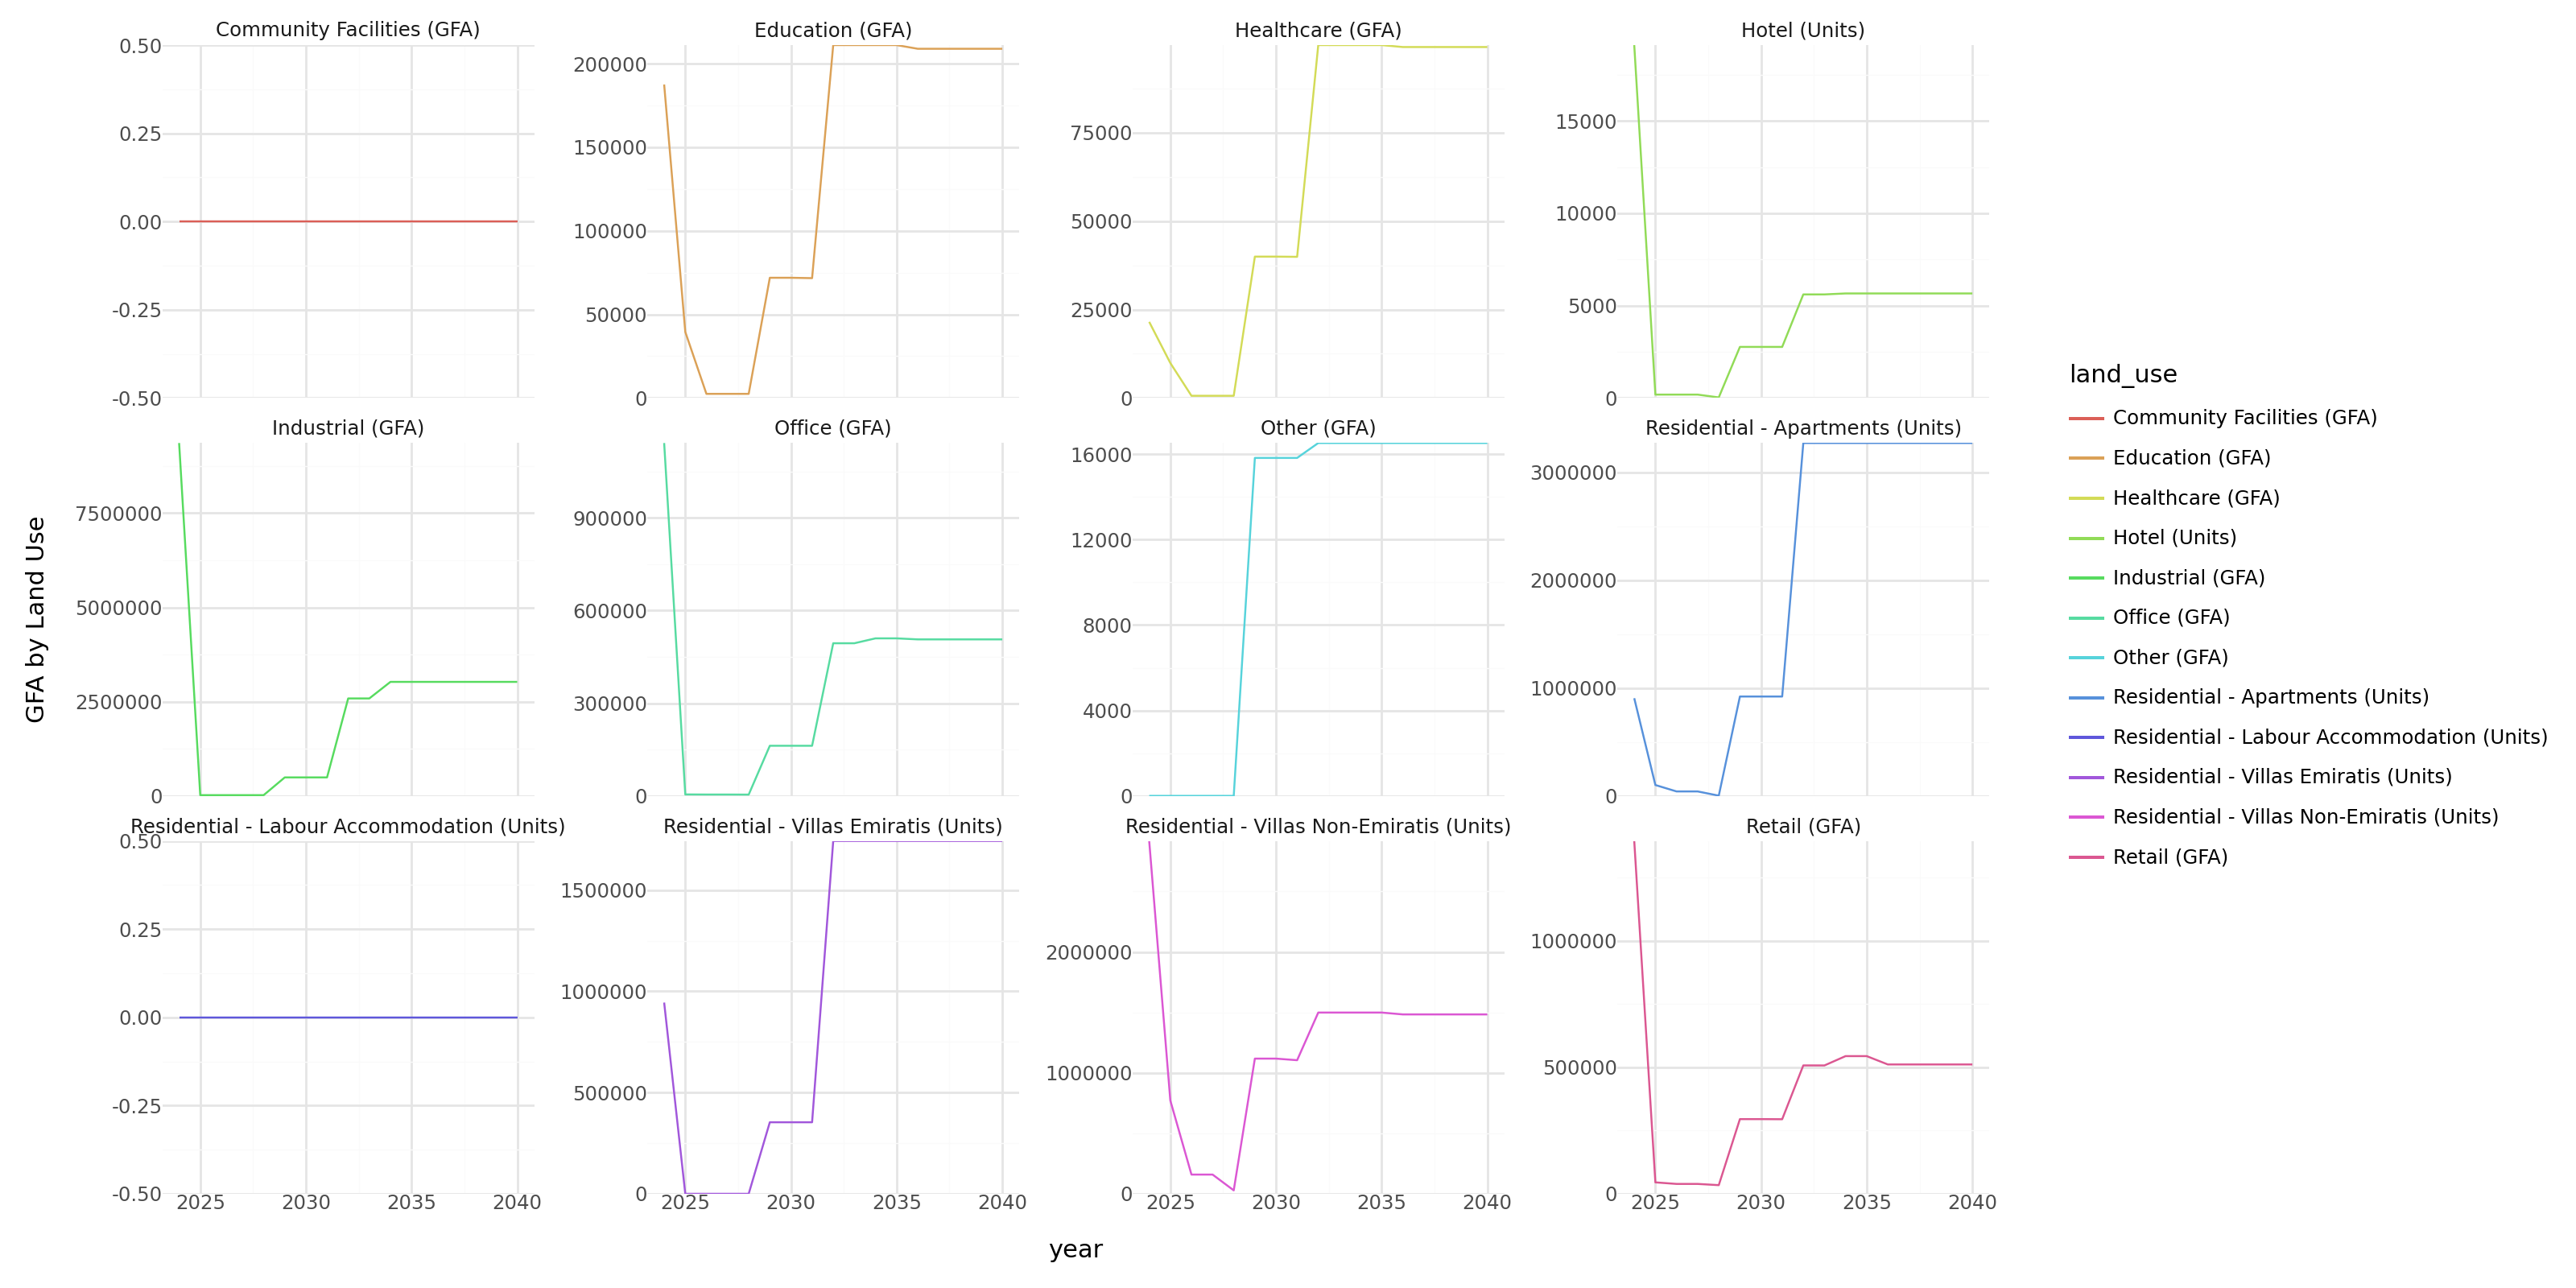

In [24]:
chart_df = development_phased.groupby(['year','land_use'])['development_pa'].sum()
chart_df = chart_df.reset_index()
chart_df['year'] = chart_df['year'].astype(int)
(p9.ggplot(chart_df,p9.aes(x = 'year',y = 'development_pa')) +
p9.geom_line(p9.aes(colour = 'land_use')) +
p9.scale_y_continuous(name = 'GFA by Land Use',expand=(0, 0),limits = (0,None)) +
p9.facet_wrap('~land_use',scales = 'free_y') +
p9.theme_minimal() +
p9.theme(figure_size=(16, 8)))

In [25]:
development_phased.to_csv('pipeline_example_output.csv')